In [1]:
import warnings
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("../word2vec/correct_false.csv")


In [3]:
train_df , test_df = train_test_split (
        data , 
        test_size = 0.2 , 
        random_state = 42 , 
        stratify = data["label"] 
    )

In [4]:
class_counts  = train_df["label"].value_counts()

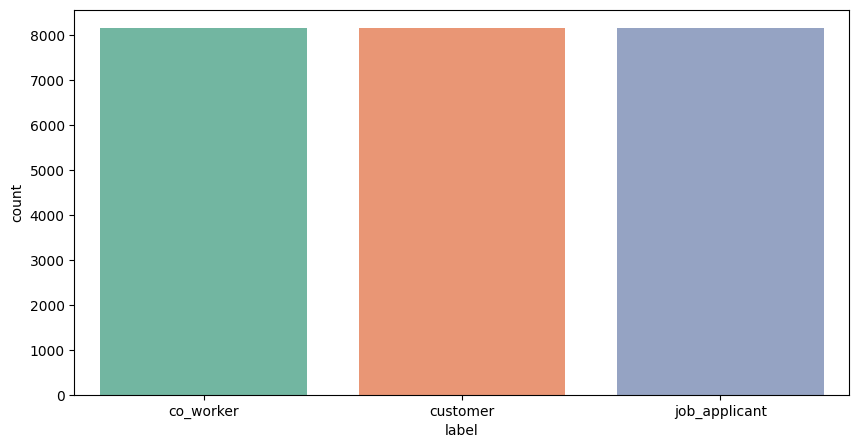

In [5]:
plt.figure(figsize = (10 , 5 ) )
sns.countplot( data = train_df ,  x = "label" , order = class_counts.index , palette = "Set2")
plt.show()

In [6]:
import re

def tokenizer(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r',' , ' ' , text)
    text = re.sub(r'\.' , ' ' , text ) 
    text = re.sub(r'-' , ' ' , text ) 
    return text


In [8]:
train_df["clean_text"] = train_df["email_body"].apply(tokenizer)

In [9]:
label_mapping = {
    "customer" : 0 , 
    "co_worker" : 1 ,
    "job_applicant" : 2
}

train_df["label_encoding"] = train_df["label"].map(label_mapping)

In [11]:
test_df["clean_text"] = test_df["email_body"].apply(tokenizer)
test_df["label_encoding"]  = test_df["label"].map(label_mapping)

In [12]:
test_df

,email_body,label,clean_text,label_encoding
17494,"Good morning William,\n\nI hope this email fin...",customer,good morning william i hope this email finds...,0
10100,"Hi Amanda,\n\nThank you for your continued par...",customer,hi amanda thank you for your continued partn...,0
28311,"Good afternoon Paul,\n\nRegarding our discussi...",co_worker,good afternoon paul regarding our discussion...,1
29942,"Hi team,\n\nQuick question about...\n\nJust a ...",co_worker,hi team quick question about just a quic...,1
10814,"Good morning Joseph,\n\nI hope this email find...",customer,good morning joseph i hope this email finds ...,0
...,...,...,...,...
25618,"Hello Riley,\n\nRegarding our discussion earli...",co_worker,hello riley regarding our discussion earlier...,1
1437,"Good morning,\n\nWith 11 years of experience i...",job_applicant,good morning with 11 years of experience in ...,2
9570,I am a highly motivated software developer see...,job_applicant,i am a highly motivated software developer see...,2
2291,"Hi there,\n\nMy colleague, Dr. Evelyn Reed, su...",job_applicant,hi there my colleague dr evelyn reed sugg...,2


In [13]:
X = train_df["clean_text"]
y = train_df["label"]

In [14]:
X_train , X_test , y_train , y_test = train_test_split ( 
    X , 
    y , 
    test_size = 0.2 , 
    random_state = 42 ,
    stratify = y )

In [15]:
tfidf_vectorizer = TfidfVectorizer(
    max_features = 15 , 
    ngram_range = ( 1 , 2 ),
    stop_words = "english"
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

X_val_tfidf = tfidf_vectorizer.transform(X_test)
X_test_tfidf = tfidf_vectorizer.transform(test_df["clean_text"])



In [16]:
train_df[ train_df["label"] == "customer" ]

,email_body,label,clean_text,label_encoding
18560,"Hello Olivia,\n\nI'm writing regarding our sub...",customer,hello olivia i'm writing regarding our subsc...,0
13798,"Greetings,\n\nI hope this email finds you well...",customer,greetings i hope this email finds you well ...,0
12494,"Hello Vertex Enterprises support,\n\nI trust y...",customer,hello vertex enterprises support i trust you...,0
18624,"Dear valued client,\n\nThank you for your inqu...",customer,dear valued client thank you for your inquir...,0
16023,"Good morning James,\n\nI trust you're having a...",customer,good morning james i trust you're having a p...,0
...,...,...,...,...
12869,"Hi Riley,\n\nThank you for sharing your future...",customer,hi riley thank you for sharing your future p...,0
19414,"Good afternoon Noah,\n\nThank you for your con...",customer,good afternoon noah thank you for your conti...,0
10276,"Greetings,\n\nI'm writing regarding our accoun...",customer,greetings i'm writing regarding our account ...,0
15475,"Greetings from the GlobalServe team,\n\nThank ...",customer,greetings from the globalserve team thank yo...,0


In [17]:
from sklearn.naive_bayes import MultinomialNB


model = LogisticRegression(max_iter=1000 , verbose = 2)
model.fit(X_train_tfidf, y_train)
logistic_score = model.score(X_val_tfidf , y_test)

model_1 = MultinomialNB( )
model_1.fit(X_train_tfidf , y_train)
naive_score = model_1.score(X_val_tfidf , y_test)

print (f"LogisticRegression Score is {logistic_score * 100: .2f} %")
print()
print (f"naive bayes score        is {naive_score * 100: .2f} %") 

LogisticRegression Score is  85.64 %

naive bayes score        is  77.59 %


In [18]:
y_pred = model.predict(X_val_tfidf)


In [19]:
# Saving the models and the vectorizer
import joblib
joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.pkl")

# Save your trained model (e.g., a classifier)
joblib.dump(model, "model.pkl")

['model.pkl']

In [20]:
import re
import joblib
def predict_(text):
    
    def tokenizer(text):
        text = text.lower()
        text = re.sub(r'\n', ' ', text)
        text = re.sub(r',' , ' ' , text)
        text = re.sub(r'\.' , ' ' , text ) 
        text = re.sub(r'-' , ' ' , text ) 
        return text
    
    loaded_vectorizer = joblib.load("tfidf_vectorizer.pkl")
    loaded_model = joblib.load("model.pkl")
    
    text = tokenizer(text)
    text_idf = loaded_vectorizer.transform([text])
    prediction = loaded_model.predict(text_idf)

    return prediction
    



In [21]:
predict_(text)

NameError: name 'text' is not defined

In [58]:
def predict(text):
    text = tokenizer(text)
    text_idf = tfidf_vectorizer.transform([text])
    return model.predict(text_idf)

In [26]:
text = """
    Dear Hiring Manager
    name is abdelmoughit EL Ouaad , I am a student a FSTM
    i want to express my interest for data science postion
"""
word_predicted = predict(text)[0]
print(f" the class predicted is   \"{word_predicted}\"")

 the class predicted is   "job_applicant"


In [27]:
text = """
    Dear Hiring Manager
    name is abdelmoughit EL Ouaad , I am a student a FSTM
    i want to express my interest for data science postion
    project project project
"""
word_predicted = predict(text)[0]
print(f" the class predicted is   \"{word_predicted}\"")

 the class predicted is   "job_applicant"


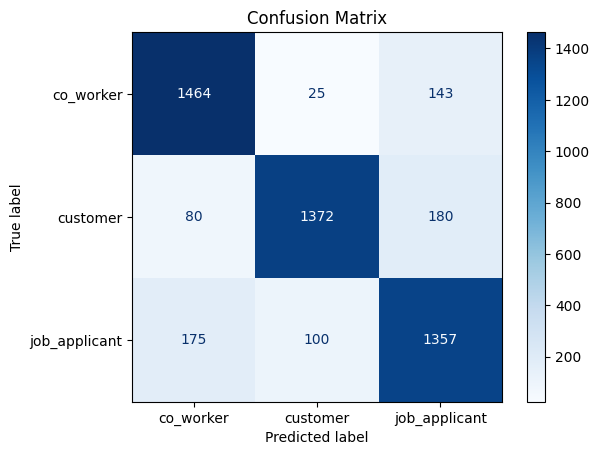

In [22]:
cm = confusion_matrix (y_test , y_pred , labels = model.classes_ )
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()



In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


               precision    recall  f1-score   support

    co_worker       0.85      0.90      0.87      1632
     customer       0.92      0.84      0.88      1632
job_applicant       0.81      0.83      0.82      1632

     accuracy                           0.86      4896
    macro avg       0.86      0.86      0.86      4896
 weighted avg       0.86      0.86      0.86      4896



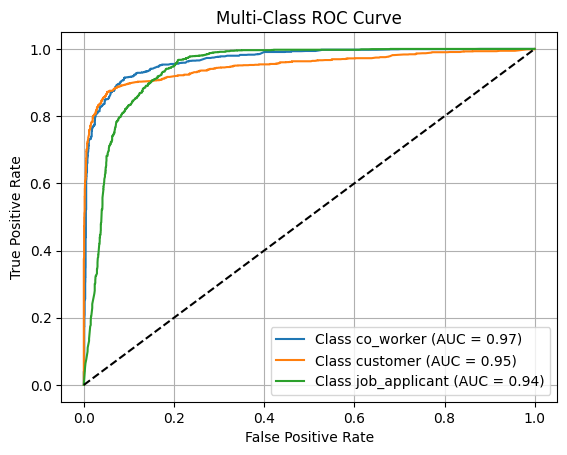

In [24]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
import numpy as np

classes = model.classes_  
y_test_bin = label_binarize(y_test, classes=classes)
y_score = model.predict_proba(X_val_tfidf)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [78]:
import requests 
email_body = "i have this problem your products , can you assist me on this ?  i'm having this issue with your products"
url = f"http://localhost:5000/classification?email_body={email_body}"

response = requests.post(url)
response.json()

{'prediction': 'customer'}